<div dir="rtl" style="text-align: right;">


# این کد با استفاده از معیار **BIC**، بهینه‌ترین مدل **Graphical Lasso** را برای یادگیری ساختار شبکه وابستگی بین متغیرها انتخاب می‌کند. این رویکرد به شما کمک می‌کند تا با یافتن تعادل میان سادگی و دقت، روابط کلیدی در داده‌ها را به بهترین شکل کشف کنید.

In [1]:
import numpy as np
from sklearn.covariance import GraphicalLasso
from itertools import combinations
import pandas as pd

def bic_score(emp_cov, precision, n_samples):
    """ محاسبه BIC برای مدل با precision matrix داده شده """
    p = emp_cov.shape[0]
    # log-likelihood
    ll = n_samples/2.0 * (np.linalg.slogdet(precision)[1]
                         - np.trace(emp_cov @ precision))
    # df = تعداد پارامترهای آزاد = تعداد غیرصفرهای بالادیاست
    # (درایه‌ی بالایی قطرِ اصلی)
    mask = np.triu(precision, k=1) != 0
    df = np.count_nonzero(mask) + p
    bic = -2*ll + np.log(n_samples)*df
    return bic

def select_graph_via_bic(X, alphas):
    """
    ورودی:
      X : ndarray n×p نمونه‌ها
      alphas : لیست λهای GraphicalLasso
    خروجی:
      بهترین precision_, بهترین λ، جدول نتایج
    """
    n, p = X.shape
    emp_cov = np.cov(X, rowvar=False)
    results = []
    best_bic = np.inf
    best_model = None

    for alpha in alphas:
        model = GraphicalLasso(alpha=alpha, max_iter=200, tol=1e-4)
        model.fit(X)
        Θ = model.precision_
        bic = bic_score(emp_cov, Θ, n)
        results.append((alpha, bic, Θ))
        if bic < best_bic:
            best_bic = bic
            best_model = (alpha, Θ)

    return best_model, results

# مثال کاربردی
if __name__ == "__main__":
    # شبیه‌سازی داده‌ی چندمتغیره نرمال
    np.random.seed(0)
    p = 10
    # مثال: precision matrَix ساختگی
    Θ_true = np.eye(p)
    for (i,j) in combinations(range(p),2):
        if np.random.rand() < 0.2:
            Θ_true[i,j] = Θ_true[j,i] = 0.4
    Σ_true = np.linalg.inv(Θ_true)
    X = np.random.multivariate_normal(np.zeros(p), Σ_true, size=200)

    alphas = np.logspace(-2, 0, 20)
    (best_alpha, best_Θ), results = select_graph_via_bic(X, alphas)

    print(f"بهترین alpha (λ) بر اساس BIC: {best_alpha:.4f}")
    print("ماتریس دقت برآوردی:\n", np.round(best_Θ, 3))
    # می‌توانید نتایج را در یک DataFrame نمایش دهید:

    df = pd.DataFrame(results, columns=['alpha','BIC','precision_matrix'])
    print(df[['alpha','BIC']])


بهترین alpha (λ) بر اساس BIC: 0.1438
ماتریس دقت برآوردی:
 [[ 1.071 -0.    -0.     0.    -0.     0.    -0.     0.    -0.     0.   ]
 [-0.     0.736 -0.     0.    -0.033 -0.    -0.     0.254  0.279  0.237]
 [-0.    -0.     0.984 -0.    -0.     0.    -0.    -0.     0.    -0.   ]
 [ 0.     0.    -0.     0.934  0.306  0.     0.339  0.     0.    -0.   ]
 [-0.    -0.033 -0.     0.306  0.992 -0.    -0.105 -0.027  0.     0.403]
 [ 0.    -0.     0.     0.    -0.     1.072  0.    -0.    -0.    -0.   ]
 [-0.    -0.    -0.     0.339 -0.105  0.     1.01  -0.    -0.     0.   ]
 [ 0.     0.254 -0.     0.    -0.027 -0.    -0.     0.944 -0.     0.192]
 [-0.     0.279  0.     0.     0.    -0.    -0.    -0.     0.898 -0.   ]
 [ 0.     0.237 -0.    -0.     0.403 -0.     0.     0.192 -0.     0.831]]
       alpha          BIC
0   0.010000  2420.526833
1   0.012743  2410.879299
2   0.016238  2401.599815
3   0.020691  2398.192685
4   0.026367  2390.308235
5   0.033598  2378.130845
6   0.042813  2361.608907
7  

<div dir="rtl" style="text-align: right;">


# این کد به صورت جامع، وجود و تعداد چرخه‌ها را در یک گراف جهت‌دار از شبکه خیابان‌ها بررسی می‌کند. سپس با پیاده‌سازی پنج روش مختلف، یال‌های اضافی را حذف کرده و گراف را به یک **مدل غیرمدور (DAG)** تبدیل می‌کند.

In [ ]:
pip install osmnx


--- Results ---
Simple Cycle Removal: Removed 0 edges | DAG? False


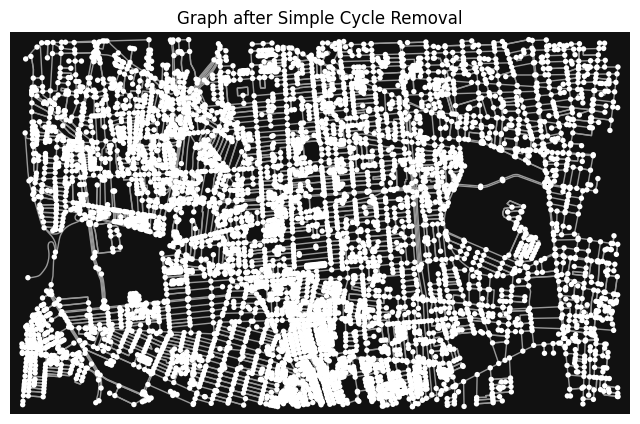

Topological Sort: Removed 0 edges | DAG? False


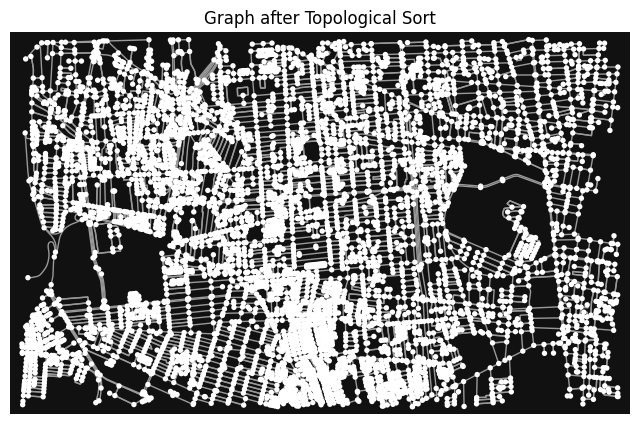

SCC Removal: Removed 113 edges | DAG? False


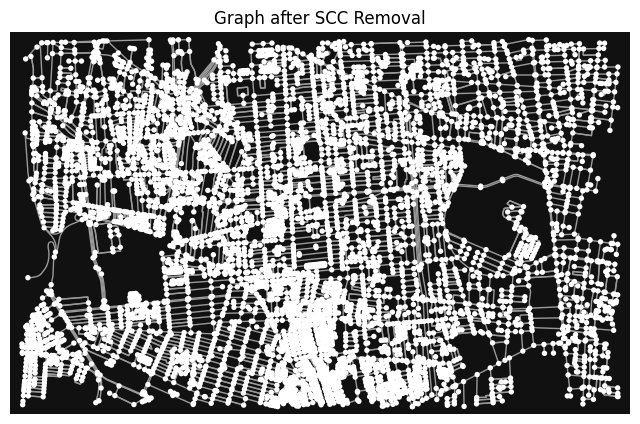

Approx MFAS: Removed 6059 edges | DAG? False


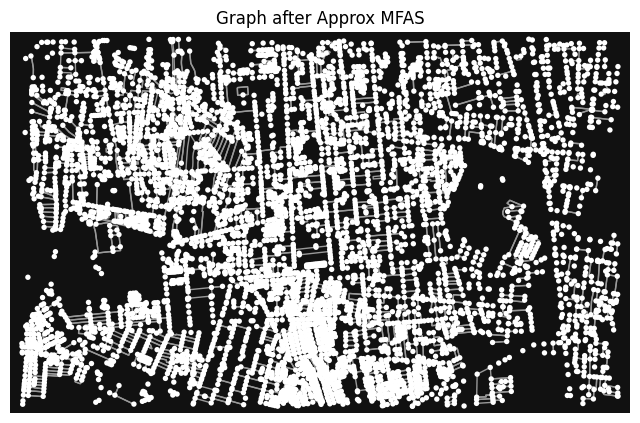

Cost-Based: Removed 0 edges | DAG? False


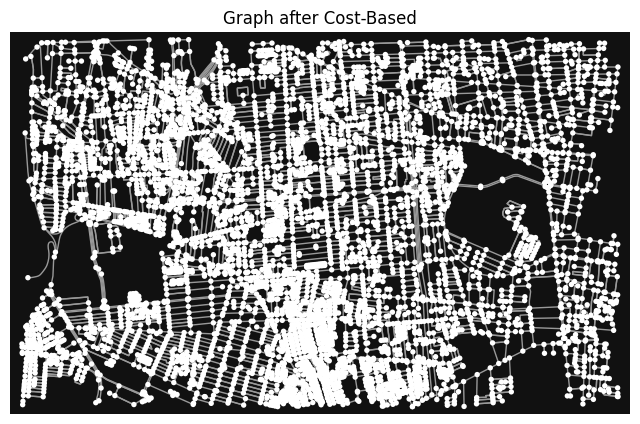

In [10]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import box

# ==============================
# تنظیمات اولیه
# ==============================
# محدوده منطقه 10 تهران
tehran_regions_bbox = {
    "10": box(51.34, 35.67, 51.4, 35.7)
}

def get_tehran_region_graph(region_number):
    """دریافت گراف منطقه مشخص‌شده تهران"""
    if region_number not in tehran_regions_bbox:
        raise ValueError("ناحیه وارد شده تعریف نشده است.")
    region_polygon = tehran_regions_bbox[region_number]
    return ox.graph_from_polygon(region_polygon, network_type="drive")

def visualize_graph(graph, method_name):
    """ترسیم گراف بعد از اعمال روش"""
    ox.plot_graph(graph, show=False)
    plt.title(f"Graph after {method_name}")
    plt.show()

# ==============================
# دریافت گراف منطقه
# ==============================
region_number = "10"
G = get_tehran_region_graph(region_number)

# ==============================
# متدهای حذف چرخه
# ==============================

# روش 1: حذف ساده با cycle detection
def remove_cycles_simple(graph):
    g = graph.copy()
    removed_edges = []
    while True:
        try:
            cycle = next(nx.simple_cycles(g))
            if len(cycle) > 1:
                u, v = cycle[0], cycle[1]
                if g.has_edge(u, v):
                    g.remove_edge(u, v)
                    removed_edges.append((u, v))
                elif g.has_edge(v, u):
                    g.remove_edge(v, u)
                    removed_edges.append((v, u))
            else:
                break
        except StopIteration:
            break
    return g, removed_edges

# روش 2: حذف چرخه با Topological Sort
def remove_cycles_topological(graph):
    g = graph.copy()
    removed_edges = []
    while True:
        try:
            list(nx.topological_sort(g))
            break  # گراف DAG شد
        except nx.NetworkXUnfeasible:
            try:
                cycle = next(nx.simple_cycles(g))
                if len(cycle) > 1:
                    u, v = cycle[0], cycle[1]
                    if g.has_edge(u, v):
                        g.remove_edge(u, v)
                        removed_edges.append((u, v))
                    elif g.has_edge(v, u):
                        g.remove_edge(v, u)
                        removed_edges.append((v, u))
                else:
                    break
            except StopIteration:
                break
    return g, removed_edges

# روش 3: حذف چرخه با SCC
def remove_cycles_scc(graph):
    g = graph.copy()
    removed_edges = []
    sccs = list(nx.strongly_connected_components(g))
    for comp in sccs:
        if len(comp) > 1:
            subgraph = g.subgraph(comp)
            u, v = next(iter(subgraph.edges()))
            if g.has_edge(u, v):
                g.remove_edge(u, v)
                removed_edges.append((u, v))
            elif g.has_edge(v, u):
                g.remove_edge(v, u)
                removed_edges.append((v, u))
    return g, removed_edges

# روش 4: تقریبی MFAS (Greedy)
def approx_mfas(graph, max_iterations=10000):
    g = graph.copy()
    removed_edges = []
    iteration = 0
    while not nx.is_directed_acyclic_graph(g) and iteration < max_iterations:
        max_diff, node_choice = float("-inf"), None
        for node in g.nodes():
            diff = g.out_degree(node) - g.in_degree(node)
            if diff > max_diff:
                max_diff, node_choice = diff, node
        if node_choice is not None:
            outgoing = list(g.out_edges(node_choice))
            if outgoing:
                u, v = outgoing[0]
                g.remove_edge(u, v)
                removed_edges.append((u, v))
        iteration += 1
    return g, removed_edges

# روش 5: ساده‌سازی مبتنی بر هزینه (cost=1)
def remove_cycles_cost_based(graph):
    g = graph.copy()
    removed_edges = []
    while not nx.is_directed_acyclic_graph(g):
        try:
            cycle = next(nx.simple_cycles(g))
            if len(cycle) > 1:
                u, v = cycle[0], cycle[1]
                if g.has_edge(u, v):
                    g.remove_edge(u, v)
                    removed_edges.append((u, v))
                elif g.has_edge(v, u):
                    g.remove_edge(v, u)
                    removed_edges.append((v, u))
            else:
                break
        except StopIteration:
            break
    return g, removed_edges

# ==============================
# اجرای متدها و مقایسه
# ==============================
methods = {
    "Simple Cycle Removal": remove_cycles_simple,
    "Topological Sort": remove_cycles_topological,
    "SCC Removal": remove_cycles_scc,
    "Approx MFAS": approx_mfas,
    "Cost-Based": remove_cycles_cost_based,
}

print("\n--- Results ---")
for name, method in methods.items():
    g_new, removed_edges = method(G)
    print(f"{name}: Removed {len(removed_edges)} edges | DAG? {nx.is_directed_acyclic_graph(g_new)}")
    visualize_graph(g_new, name)


<div dir="rtl" style="text-align: right;">


#این کد با استفاده از چندین رویکرد آماری، ساختاری و الگوریتمی (شامل اطلاعات متقابل، درجه گره، تحلیل عاملی و الگوریتم‌های تکاملی و حریصانه) به شناسایی و رتبه‌بندی مهم‌ترین متغیرها در یک شبکه بیزی می‌پردازد.

In [ ]:
pip install pomegranate

In [ ]:
pip install pgmpy

In [9]:
import gzip
from pgmpy.readwrite import BIFReader
from io import StringIO
import pandas as pd
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
# 1. لود دیتای آسیا


# تعریف ساختار Asia network
model = BayesianNetwork([
    ('asia', 'tub'),
    ('smoke', 'lung'),
    ('smoke', 'bronc'),
    ('tub', 'either'),
    ('lung', 'either'),
    ('either', 'xray'),
    ('either', 'dysp'),
    ('bronc', 'dysp')
])

# تعریف CPD ها
cpd_asia = TabularCPD('asia', 2, [[0.99], [0.01]])
cpd_smoke = TabularCPD('smoke', 2, [[0.5], [0.5]])
cpd_tub = TabularCPD('tub', 2, [[0.99, 0.95], [0.01, 0.05]], evidence=['asia'], evidence_card=[2])
cpd_lung = TabularCPD('lung', 2, [[0.99, 0.9], [0.01, 0.1]], evidence=['smoke'], evidence_card=[2])
cpd_bronc = TabularCPD('bronc', 2, [[0.7, 0.4], [0.3, 0.6]], evidence=['smoke'], evidence_card=[2])
cpd_either = TabularCPD('either', 2,
                        [[1, 0, 0, 0],
                         [0, 1, 1, 1]],
                        evidence=['lung', 'tub'],
                        evidence_card=[2, 2])
cpd_xray = TabularCPD('xray', 2, [[0.95, 0.02], [0.05, 0.98]], evidence=['either'], evidence_card=[2])
cpd_dysp = TabularCPD('dysp', 2,
                      [[0.9, 0.7, 0.8, 0.1],
                       [0.1, 0.3, 0.2, 0.9]],
                      evidence=['bronc', 'either'],
                      evidence_card=[2, 2])

model.add_cpds(cpd_asia, cpd_smoke, cpd_tub, cpd_lung,
               cpd_bronc, cpd_either, cpd_xray, cpd_dysp)
# 2. توابع محاسبه معیارها
def calculate_mutual_information(data, x, y):
    """محاسبه اطلاعات متقابل بین دو متغیر."""
    return mutual_info_score(data[x], data[y])

def calculate_conditional_entropy(data, y, x):
    """محاسبه آنتروپی شرطی Y با توجه به X."""
    p_xy = pd.crosstab(data[x], data[y], normalize='index')
    entropy_y_given_x = 0
    for xi in p_xy.index:
        entropy_y_given_x += entropy(p_xy.loc[xi], base=2) * data[x].value_counts(normalize=True)[xi]
    return entropy_y_given_x

def calculate_bic_score(data):
    """محاسبه تقریبی معیار اطلاعات بیزین (BIC)."""
    n = len(data)  # تعداد نمونه‌ها
    k = len(data.columns)  # تعداد متغیرها
    likelihood = 1  # مقدار درست‌نمایی (likelihood) را باید بر اساس مدل خود محاسبه کنید
    bic = -2 * np.log(likelihood) + k * np.log(n)
    return bic

# 3. محاسبه معیارها برای همه متغیرها
variables = data.columns
mi_matrix = pd.DataFrame(index=variables, columns=variables)
conditional_entropy_matrix = pd.DataFrame(index=variables, columns=variables)

for x in variables:
    for y in variables:
        mi_matrix.loc[x, y] = calculate_mutual_information(data, x, y)
        conditional_entropy_matrix.loc[x, y] = calculate_conditional_entropy(data, y, x)

# 4. مرتب‌سازی گره‌ها بر اساس معیارها
def order_nodes_by_mutual_information(mi_matrix, start_node):
    """مرتب‌سازی گره‌ها بر اساس اطلاعات متقابل."""
    ordered_nodes = [start_node]
    remaining_nodes = list(mi_matrix.index)
    remaining_nodes.remove(start_node)
    while remaining_nodes:
        next_node = max(remaining_nodes, key=lambda node: mi_matrix.loc[ordered_nodes[-1], node])
        ordered_nodes.append(next_node)
        remaining_nodes.remove(next_node)
    return ordered_nodes

def order_nodes_by_conditional_entropy(conditional_entropy_matrix, start_node):
    """مرتب‌سازی گره‌ها بر اساس آنتروپی شرطی."""
    ordered_nodes = [start_node]
    remaining_nodes = list(conditional_entropy_matrix.index)
    remaining_nodes.remove(start_node)
    while remaining_nodes:
        next_node = min(remaining_nodes, key=lambda node: conditional_entropy_matrix.loc[ordered_nodes[-1], node])
        ordered_nodes.append(next_node)
        remaining_nodes.remove(next_node)
    return ordered_nodes

# 5. ایجاد جدول مقایسه‌ای
comparison_table = pd.DataFrame(index=variables)
for start_node in variables:
    comparison_table[f'MI_{start_node}'] = order_nodes_by_mutual_information(mi_matrix, start_node)
    comparison_table[f'CE_{start_node}'] = order_nodes_by_conditional_entropy(conditional_entropy_matrix, start_node)

# 6. نمایش نتایج
comparison_table

import pandas as pd
# Instead of 'pomegranate', import 'BIFReader' from 'pgmpy'
from pgmpy.readwrite import BIFReader
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler



# Assuming 'data' contains categorical features, you need to encode them before scaling.
# If 'data' already contains numerical values, you can skip this step and use 'data' directly.
# Here's an example using pandas' get_dummies for one-hot encoding:
data_encoded = pd.get_dummies(data, columns=data.select_dtypes(include=['object']).columns)

# استانداردسازی داده‌ها
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_encoded)

# اعمال تحلیل عاملی (تعداد عوامل را باید بر اساس داده‌ها تعیین کنید)
n_components = min(data_scaled.shape[1], 5) # به عنوان مثال، حداکثر 5 عامل یا تعداد متغیرها
fa = FactorAnalysis(n_components=n_components, random_state=42)
fa.fit(data_scaled)

# بررسی بارگذاری عوامل بر روی متغیرها
loadings = pd.DataFrame(fa.components_.T, columns=[f'Factor{i+1}' for i in range(n_components)], index=data_encoded.columns)
print("\nبارگذاری عوامل بر روی متغیرها:")
print(loadings)

# محاسبه "اهمیت" هر متغیر بر اساس بارگذاری‌ها (مثال: مجموع قدر مطلق بارگذاری‌ها)
importance = loadings.abs().sum(axis=1).sort_values(ascending=False)
print("\nاهمیت متغیرها بر اساس تحلیل عاملی:")
print(importance)

import pandas as pd
from pgmpy.readwrite import BIFReader



node_degrees = {}
for node in model.nodes(): # Iterate through nodes using model.nodes()
    parents = len(list(model.predecessors(node)))  # Get parents using model.predecessors()
    children = len(list(model.successors(node)))  # Get children using model.successors()
    node_degrees[node] = parents + children

# مرتب سازی بر اساس درجه
sorted_degrees = sorted(node_degrees.items(), key=lambda item: item[1], reverse=True)
print("\nاهمیت نودها بر اساس درجه (تعداد والدین + فرزندان):")
for node, degree in sorted_degrees:
    print(f"نود '{node}': {degree}")

!pip install deap


import gzip
import pandas as pd
import numpy as np
from pgmpy.readwrite import BIFReader
from pgmpy.estimators import BicScore, K2Score, HillClimbSearch
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score
from sklearn.decomposition import FactorAnalysis
from deap import base, creator, tools, algorithms
import random

# 1. Load data (assuming you've already loaded `data` as a pandas DataFrame)


# List of nodes
nodes = list(data.columns)

# 2. Evolutionary Algorithm: select top-k nodes maximizing BIC score of induced submodel

def evolutionary_node_selection(data, nodes, pop_size=40, ngen=30, k=3):
    n = len(nodes)
    bic = BicScore(data)

    # Fitness: BIC score of submodel on selected nodes
    def eval_subset(individual):
        selected = [nodes[i] for i, bit in enumerate(individual) if bit]
        if len(selected) < 1:
            return -1e6,
        # Calculate BIC score by iterating through selected nodes
        score = sum(bic.local_score(node, set(selected) - {node}) for node in selected)
        return score,
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", eval_subset)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    pop = toolbox.population(n=pop_size)
    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=ngen, verbose=False)
    top = tools.selBest(pop, k=5)
    # Count frequency of nodes in top individuals
    freq = np.sum([ind for ind in top], axis=0)
    ranking = sorted(zip(nodes, freq), key=lambda x: x[1], reverse=True)
    return ranking

# Usage:
evo_rank = evolutionary_node_selection(data, nodes)
print("Evolutionary ranking:", evo_rank)

# 3. Heuristic Greedy Forward Selection (K2 score)
def greedy_forward_selection(data, nodes):
    k2 = K2Score(data)
    selected = []
    remaining = set(nodes)
    order = []
    while remaining:
        best_node, best_score = None, -np.inf
        for node in remaining:
            score = k2.local_score(node, set(selected))
            if score > best_score:
                best_score = score
                best_node = node
        selected.append(best_node)
        order.append((best_node, best_score))
        remaining.remove(best_node)
    return order

# Usage:
greedy_order = greedy_forward_selection(data, nodes)
print("Greedy forward order:", greedy_order)

# 4. SORDER & Mutual Information ranking
def mutual_information_ranking(data, nodes):
    mi_scores = {}
    for node in nodes:
        others = [n for n in nodes if n != node]
        # Sum MI with each other node
        mi_sum = sum(mutual_info_score(data[node], data[other]) for other in others)
        mi_scores[node] = mi_sum
    ranking = sorted(mi_scores.items(), key=lambda x: x[1], reverse=True)
    return ranking

# Usage:
mi_rank = mutual_information_ranking(data, nodes)
print("MI ranking:", mi_rank)

# 5. Conditional Entropy: H(X|Rest)
def conditional_entropy_ranking(data, nodes):
    ce_scores = {}
    for node in nodes:
        joint = data
        # H(X|Rest) = H(all) - H(Rest)
        # Approximate via entropy of concatenated strings
        joint_series = joint.astype(str).agg('-'.join, axis=1)
        rest_series = data.drop(columns=node).astype(str).agg('-'.join, axis=1)
        H_all = -sum(p * np.log2(p) for p in joint_series.value_counts(normalize=True))
        H_rest = -sum(p * np.log2(p) for p in rest_series.value_counts(normalize=True))
        ce_scores[node] = H_all - H_rest
    ranking = sorted(ce_scores.items(), key=lambda x: x[1])  # smaller H|Rest = more determined
    return ranking

# Usage:
ce_rank = conditional_entropy_ranking(data, nodes)
print("Conditional entropy ranking:", ce_rank)

# 6. Factor Analysis: node contributions to first factor

def factor_analysis_ranking(data, n_factors=1):
    fa = FactorAnalysis(n_components=n_factors)
    transformed = fa.fit_transform(data.apply(lambda col: pd.factorize(col)[0]))
    loadings = pd.DataFrame(fa.components_.T, index=data.columns, columns=[f'Factor{i+1}' for i in range(n_factors)])
    ranking = loadings[f'Factor1'].abs().sort_values(ascending=False)
    return ranking

# Usage:
fa_rank = factor_analysis_ranking(data)
print("Factor analysis ranking:", fa_rank)

# Example combined report:
# print("Evolutionary:", evo_rank)
# print("Greedy:", greedy_order)
# print("MI:", mi_rank)
# print("Cond. Entropy:", ce_rank)
# print("Factor Analysis:", fa_rank)



بارگذاری عوامل بر روی متغیرها:
         Factor1   Factor2       Factor3       Factor4       Factor5
asia    0.025836  0.000408  1.163718e-02  3.880999e-02  2.988688e-02
tub    -0.432214 -0.901771 -2.561684e-13  3.818629e-14  9.682111e-14
smoke  -0.160875  0.070369  3.770631e-01 -3.197298e-01  1.867664e-01
lung   -0.890206  0.455559 -1.605485e-13  2.302777e-13  1.624652e-13
bronc  -0.002673 -0.018237  8.532834e-01 -2.053549e-02  6.143033e-02
either -0.999875 -0.015785 -2.640227e-13  2.239950e-13  1.909585e-13
xray   -0.706833  0.032784  2.371214e-02 -2.338694e-01 -2.103116e-01
dysp   -0.139536 -0.053026  8.120653e-01  9.327125e-02 -1.051494e-01

اهمیت متغیرها بر اساس تحلیل عاملی:
lung      1.345764
tub       1.333985
xray      1.207509
dysp      1.203048
smoke     1.114803
either    1.015661
bronc     0.956160
asia      0.106578
dtype: float64

اهمیت نودها بر اساس درجه (تعداد والدین + فرزندان):
نود 'either': 4
نود 'tub': 2
نود 'smoke': 2
نود 'lung': 2
نود 'bronc': 2
نود 'dysp': 2
نود '

In [11]:
import gzip
import numpy as np
import pandas as pd
import networkx as nx
from pgmpy.readwrite import BIFReader
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
from itertools import combinations



# تبدیل داده‌ها به عددی
# ابتدا همه ستون‌ها را به مقدار عددی و در غیر این صورت نمایش خطا
for col in data.columns:
    if data[col].dtype.name == 'category':
        data[col] = data[col].map({'yes': 1, 'no': 0})
    # بررسی تبدیل کامل
    if data[col].isnull().any():
        print(f"ستون '{col}' هنوز مقدار نامعتبر دارد: {data[col].unique()}")

# تبدیل تمام داده‌ها به int (در صورت نبود مقدار NaN)
try:
    data_numeric = data.astype(int)
except Exception as e:
    print(f"خطا در تبدیل کامل داده‌ها به عدد: {e}")

# لیست گره‌ها (متغیرها)
nodes = list(data_numeric.columns)

# تابع برای محاسبه اطلاعات متقابل (Mutual Information)
def calculate_mutual_information(data, node1, node2):
    return mutual_info_score(data[node1], data[node2])

# تابع برای محاسبه آنتروپی (Entropy)
def calculate_entropy(data, node):
    value_counts = data[node].value_counts(normalize=True)
    return entropy(value_counts)

# تابع برای محاسبه آنتروپی شرطی (Conditional Entropy)
def calculate_conditional_entropy(data, node_y, node_x):
    joint_prob = pd.crosstab(data[node_x], data[node_y], normalize=True)
    prob_x = data[node_x].value_counts(normalize=True)
    cond_entropy = 0
    for x in prob_x.index:
        for y in joint_prob.index:
            if joint_prob.loc[y, x] > 0:
                cond_entropy -= joint_prob.loc[y, x] * np.log2(joint_prob.loc[y, x] / prob_x[x])
    return cond_entropy

# تابع سفارشی برای محاسبه امتیاز BIC
def calculate_bic_score(data, graph, nodes):
    n = len(nodes)
    N = len(data)
    score = 0
    for i, node in enumerate(nodes):
        parents = list(graph.predecessors(node)) if node in graph else []
        if not parents:
            value_counts = data[node].value_counts()
            for k in value_counts.index:
                N_ijk = value_counts.get(k, 0)
                N_ij = N
                if N_ijk > 0:
                    score += N_ijk * np.log(N_ijk / N_ij)
            r_i = len(value_counts)
            penalty = 0.5 * (r_i - 1) * np.log(N)
            score -= penalty
        else:
            parent_configs = data[parents].drop_duplicates()
            q_i = len(parent_configs)
            r_i = len(data[node].unique())
            for j in range(q_i):
                parent_config = parent_configs.iloc[j]
                N_ij = len(data[(data[parents] == parent_config).all(axis=1)])
                if N_ij > 0:
                    value_counts = data[(data[parents] == parent_config).all(axis=1)][node].value_counts()
                    for k in value_counts.index:
                        N_ijk = value_counts.get(k, 0)
                        if N_ijk > 0:
                            score += N_ijk * np.log(N_ijk / N_ij)
            penalty = 0.5 * (r_i - 1) * q_i * np.log(N)
            score -= penalty
    return score

# 1. پیاده‌سازی SORDER (بر اساس درجه گره‌ها)
def sorder(data_numeric, nodes):
    corr_matrix = data_numeric.corr()  # استفاده از داده‌های عددی
    G = nx.Graph()
    for i, j in combinations(nodes, 2):
        if abs(corr_matrix.loc[i, j]) > 0.1:  # آستانه همبستگی
            G.add_edge(i, j)

    degrees = dict(G.degree())
    ordered_nodes = sorted(nodes, key=lambda x: degrees.get(x, 0), reverse=True)
    return ordered_nodes

# 2. پیاده‌سازی Mutual Information (MI)
def mi_ordering(data, nodes):
    mi_matrix = np.zeros((len(nodes), len(nodes)))
    for i, node1 in enumerate(nodes):
        for j, node2 in enumerate(nodes):
            if i != j:
                mi_matrix[i, j] = calculate_mutual_information(data, node1, node2)

    total_mi = mi_matrix.sum(axis=1)
    start_node_idx = np.argmax(total_mi)
    ordered_nodes = [nodes[start_node_idx]]
    remaining_nodes = [n for n in nodes if n != nodes[start_node_idx]]

    while remaining_nodes:
        last_node = ordered_nodes[-1]
        last_node_idx = nodes.index(last_node)
        mi_values = [mi_matrix[last_node_idx, nodes.index(n)] for n in remaining_nodes]
        next_node_idx = np.argmax(mi_values)
        ordered_nodes.append(remaining_nodes.pop(next_node_idx))
    return ordered_nodes

# 3. پیاده‌سازی Conditional Entropy
def conditional_entropy_ordering(data, nodes):
    entropies = {node: calculate_entropy(data, node) for node in nodes}
    start_node = min(entropies, key=entropies.get)
    ordered_nodes = [start_node]
    remaining_nodes = [n for n in nodes if n != start_node]

    while remaining_nodes:
        last_node = ordered_nodes[-1]
        cond_entropies = {n: calculate_conditional_entropy(data, n, last_node) for n in remaining_nodes}
        next_node = min(cond_entropies, key=cond_entropies.get)
        ordered_nodes.append(next_node)
        remaining_nodes.remove(next_node)
    return ordered_nodes

# 4. پیاده‌سازی BIC Scoring
def bic_ordering(data, nodes):
    ordered_nodes = []
    remaining_nodes = nodes.copy()

    while remaining_nodes:
        best_score = -np.inf
        best_node = None
        for node in remaining_nodes:
            temp_nodes = ordered_nodes + [node]
            if len(temp_nodes) > 1:
                G = nx.DiGraph()
                for i in range(len(temp_nodes)-1):
                    G.add_edge(temp_nodes[i], temp_nodes[i+1])
                score = calculate_bic_score(data, G, temp_nodes)
            else:
                score = 0
            if score > best_score:
                best_score = score
                best_node = node
        ordered_nodes.append(best_node)
        remaining_nodes.remove(best_node)
    return ordered_nodes

# 5. پیاده‌سازی ITNO (Information-Theory Node Ordering)
def itno_ordering(data, nodes):
    N = len(nodes)
    mi_matrix = np.zeros((N, N))
    for i, node1 in enumerate(nodes):
        for j, node2 in enumerate(nodes):
            if i != j:
                mi_matrix[i, j] = calculate_mutual_information(data, node1, node2)

    dep_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(i+1, N):
            ok = True
            k = 0
            while ok and k < N:
                if k != i and k != j:
                    mi_ij = mi_matrix[i, j]
                    mi_ki = mi_matrix[k, i]
                    mi_jk = mi_matrix[j, k]
                    if mi_ij <= mi_ki and mi_ij <= mi_jk:
                        ok = False
                k += 1
            if k >= N:
                dep_matrix[i, j] = dep_matrix[j, i] = 1

    total_dep = dep_matrix.sum(axis=1)
    start_node_idx = np.argmax(total_dep)
    ordered_nodes = [nodes[start_node_idx]]
    remaining_nodes = [n for n in nodes if n != nodes[start_node_idx]]

    while remaining_nodes:
        last_node_idx = nodes.index(ordered_nodes[-1])
        dep_values = [dep_matrix[last_node_idx, nodes.index(n)] for n in remaining_nodes]
        next_node_idx = np.argmax(dep_values) if max(dep_values) > 0 else 0
        ordered_nodes.append(remaining_nodes.pop(next_node_idx))
    return ordered_nodes

from sklearn.decomposition import FactorAnalysis

# 6. تحلیل عاملی (Factor Analysis) برای ترتیب‌دهی گره‌ها
def factor_analysis_ordering(data, nodes):
    """
    ترتیب‌دهی گره‌ها بر اساس تحلیل عاملی
    Args:
        data (pd.DataFrame): داده‌های ورودی
        nodes (list): لیست گره‌ها (ستون‌ها)
    Returns:
        list: ترتیب گره‌ها بر اساس واریانس اشتراکی (Communalities)
    """
    # اجرای تحلیل عاملی بر اساس تعداد گره‌ها
    fa = FactorAnalysis(n_components=len(nodes), random_state=0)
    fa.fit(data)

    # واریانس اشتراکی (Communalities) هر گره
    communalities = np.sum(fa.components_ ** 2, axis=0)

    # مرتب‌سازی گره‌ها بر اساس مقدار communalities
    sorted_indices = np.argsort(communalities)[::-1]  # مرتب‌سازی نزولی
    ordered_nodes = [nodes[i] for i in sorted_indices]

    return ordered_nodes


from deap import base, creator, tools, algorithms
import random

# 7. الگوریتم ژنتیک برای ترتیب‌دهی گره‌ها
def genetic_algorithm_ordering(data, nodes):
    """
    ترتیب‌دهی گره‌ها به کمک الگوریتم ژنتیک
    Args:
        data (pd.DataFrame): داده‌های ورودی
        nodes (list): لیست گره‌ها (ستون‌ها)
    Returns:
        list: ترتیب گره‌ها بر اساس الگوریتم ژنتیک
    """
    # تعداد گره‌ها
    num_nodes = len(nodes)
    # حذف تعریف قبلی کلاس‌ها (در صورت استفاده مکرر)
    if "FitnessMin" in creator.__dict__:
        del creator.FitnessMin
    if "Individual" in creator.__dict__:
        del creator.Individual


    # تعریف فضای حل مسئله (Minimize Negative BIC Score)
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    # ابزارها برای تولید جمعیت اولیه
    toolbox = base.Toolbox()
    toolbox.register("indices", random.sample, range(num_nodes), num_nodes)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate(individual):
        """تابع ارزیابی: محاسبه امتیاز BIC برای ترتیب گره‌ها"""
        ordering = [nodes[i] for i in individual]
        model = learn_structure_simple(data, ordering)
        score = calculate_bic_score(data, model, nodes)
        return score,

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxTwoPoint)  # تقاطع دو نقطه‌ای
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)  # جابجایی تصادفی
    toolbox.register("select", tools.selTournament, tournsize=3)  # انتخاب تورنمنتی

    # تولید جمعیت اولیه
    population = toolbox.population(n=5)

    # تنظیمات الگوریتم ژنتیک
    generations = 50
    fitness_values = algorithms.eaSimple(
        population, toolbox, cxpb=0.7, mutpb=0.2, ngen=generations, verbose=False
    )

    # بهترین فرد (ترتیب گره‌ها)
    best_individual = tools.selBest(population, k=1)[0]
    best_ordering = [nodes[i] for i in best_individual]
    return best_ordering




# تابع ساده برای یادگیری ساختار با استفاده از ترتیب‌بندی
def learn_structure_simple(data, ordering):
    G = nx.DiGraph()
    for i in range(len(ordering)):
        G.add_node(ordering[i])
        if i > 0:
            for j in range(max(0, i-3), i):
                G.add_edge(ordering[j], ordering[i])
    return G

# تست تمام روش‌ها
ordering_methods = {
    "SORDER": sorder,
    "Mutual Information": mi_ordering,
    "Conditional Entropy": conditional_entropy_ordering,
    "BIC Scoring": bic_ordering,
    "ITNO": itno_ordering,
    "Factor Analysis" : factor_analysis_ordering,
    "Genetic Algorithm" : genetic_algorithm_ordering
}

# تست تمام روش‌ها (اضافه شدن روش جدید به لیست)

# تست کامل روش‌ها برای داده‌ها
results = {}
for method_name, method_func in ordering_methods.items():
    try:
        ordering = method_func(data_numeric, nodes)
        print(f"ترتیب‌بندی با روش {method_name}: {ordering}")

        model = learn_structure_simple(data_numeric, ordering)
        score = calculate_bic_score(data_numeric, model, nodes)

        results[method_name] = {
            "ordering": ordering,
            "model": model,
            "score": score
        }
        print(f"امتیاز BIC برای {method_name}: {results[method_name]['score']}")
    except Exception as e:
        print(f"خطا در اجرای روش {method_name}: {e}")
print("************************")
if results:
    best_method = max(results, key=lambda x: results[x]["score"])
    print(f"بهترین روش بر اساس امتیاز BIC: {best_method}")
    print(f"ترتیب‌بندی: {results[best_method]['ordering']}")
    print(f"امتیاز: {results[best_method]['score']}")
else:
    print("هیچ نتیجه‌ای به دلیل خطاها تولید نشد.")


ترتیب‌بندی با روش SORDER: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
امتیاز BIC برای SORDER: -5687.105362485156
ترتیب‌بندی با روش Mutual Information: ['F', 'H', 'G', 'B', 'E', 'A', 'C', 'D']
امتیاز BIC برای Mutual Information: -5680.213695441435
ترتیب‌بندی با روش Conditional Entropy: ['F', 'H', 'G', 'D', 'B', 'E', 'A', 'C']
امتیاز BIC برای Conditional Entropy: -5686.553237530306
ترتیب‌بندی با روش BIC Scoring: ['A', 'F', 'H', 'G', 'B', 'D', 'C', 'E']
امتیاز BIC برای BIC Scoring: -5681.689205742098
ترتیب‌بندی با روش ITNO: ['A', 'C', 'D', 'F', 'H', 'G', 'B', 'E']
امتیاز BIC برای ITNO: -5679.259975541419
ترتیب‌بندی با روش Factor Analysis: ['F', 'H', 'G', 'A', 'D', 'B', 'E', 'C']
امتیاز BIC برای Factor Analysis: -5685.190152142142
ترتیب‌بندی با روش Genetic Algorithm: ['E', 'A', 'B', 'D', 'C', 'A', 'G', 'F']
امتیاز BIC برای Genetic Algorithm: -5713.971047319574
************************
بهترین روش بر اساس امتیاز BIC: ITNO
ترتیب‌بندی: ['A', 'C', 'D', 'F', 'H', 'G', 'B', 'E']
امتیاز: -5679.259975